In [60]:
# Import library
import pandas as pd
import numpy as np
import pymongo
import json
import datetime
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
import time

In [4]:
# Load json data into dataframe (read directly from Mongodb)
# Declare MONGODB Instance (localhost)
mongo_client = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
mongo_db = mongo_client['myDB']
mongo_collection = mongo_db['DataMining_Trump']

# Read all data into pandas dataframe
df = pd.DataFrame(list(mongo_collection.find()))

In [5]:
df.shape

(13258, 9)

In [6]:
df.head()

,_id,created_at,id,screen_name:,lang,is_quote_status,is_retweet_status,full_text,quote_text
0,5ebe3bd2403dbfa81a78369a,2020-05-15 06:50:51,1261187267852451840,FalconhunterNRA,en,False,True,ICYMI: #FLYNNATTORNEY: Entrapment Plan Orchest...,
1,5ebe3bd6403dbfa81a78369b,2020-05-15 06:50:54,1261187283530788867,RafaelGarciaLAF,es,False,True,"#Trump dice que los médicos y enfermeras ""corr...",
2,5ebe3bdc403dbfa81a78369c,2020-05-15 06:51:00,1261187309204103168,ZA1194,en,False,False,@Neganwillclocku @AngelaBelcamino @realDonaldT...,
3,5ebe3bdd403dbfa81a78369d,2020-05-15 06:51:01,1261187312005926913,gary_burch,en,False,True,"When this pandemic is all over, the four count...",
4,5ebe3bdd403dbfa81a78369e,2020-05-15 06:51:01,1261187312429314048,Praveenkumarur3,hi,False,False,500 अरब डॉलर की बचत होगी.'' ट्रंप ने चीन से सा...,


### Things to clean:
- Checking any missing/ duplicated value
- Extract data from json object inside cell for columns `_id`, `created_at`, `id`
- Rename columns

### Text cleaning:
- For `full_text`, `quote_text` column, text preprocessing is required for sentiment analysis
- Convert to lowercase, remove noise and stopword, tokenization

Before data cleaning, create another copy of dataframe.

In [7]:
df_clean = df.copy()

#### Checking missing value

In [8]:
# Checking missing value
df_clean.isnull().sum()

_id                  0
created_at           0
id                   0
screen_name:         0
lang                 0
is_quote_status      0
is_retweet_status    0
full_text            0
quote_text           0
dtype: int64

No missing value is found.

#### Checking duplicated value

In [9]:
# Checking duplicated value
df_clean.duplicated().sum()

0

No duplicate row is found.

In [10]:
# Dataset info
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13258 entries, 0 to 13257
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   _id                13258 non-null  object        
 1   created_at         13258 non-null  datetime64[ns]
 2   id                 13258 non-null  int64         
 3   screen_name:       13258 non-null  object        
 4   lang               13258 non-null  object        
 5   is_quote_status    13258 non-null  bool          
 6   is_retweet_status  13258 non-null  bool          
 7   full_text          13258 non-null  object        
 8   quote_text         13258 non-null  object        
dtypes: bool(2), datetime64[ns](1), int64(1), object(5)
memory usage: 751.1+ KB


#### Drop Columns
`_id` is id from mongo database, thus, it is not required in this project and could be dropped.

In [11]:
df_clean.drop('_id', axis =1, inplace =True)

#### Rename Columns
- Change `id` to `user_id`  
- Change `screen_name:` to `username`
- Change `lang` to `language`

In [12]:
df_clean.rename(columns = {'id':'user_id', 'screen_name:':'username', 'lang':'language'}, inplace = True)

In [13]:
df_clean.sample(10)

,created_at,user_id,username,language,is_quote_status,is_retweet_status,full_text,quote_text
3548,2020-05-27 12:49:19,1265626137113354240,exotic_don,und,True,False,#TrumpIsAnIdiot #trump #TrumpDeathToll100K #Trump,It’s hard to wrap our brains around so many lo...
5197,2020-05-27 13:10:05,1265631360301105157,R24966786,en,False,True,Well played @narendramodi @DrSJaishankar 👌🏼🔥 #...,
2326,2020-05-15 14:26:31,1261301942657171457,freddie1999,en,False,True,US-China tensions rise as #Trump administratio...,
10849,2020-05-27 14:19:18,1265648780893990912,HinduRastraRSS,und,True,False,@ANI https://t.co/2HauSRTyXQ,@FarhanGondal @ANI @WHO #China is now divertin...
7707,2020-05-27 13:39:12,1265638687641042945,lebemitliebe,de,False,True,+ #Trump droht sozialen Medien mit Schließung ...,
12622,2020-05-27 14:41:14,1265654301881520129,timbgood,en,True,False,We have known for years that White Power adher...,"Yes, #Trump's Aide Really Did Throw ""White Pow..."
8951,2020-05-27 13:54:38,1265642573735112704,suryakant_shaha,en,False,True,Well played @narendramodi @DrSJaishankar 👌🏼🔥 #...,
10773,2020-05-27 14:18:26,1265648560521043975,realconvictdon1,en,False,False,@AndyOstroy @realDonaldTrump Actually THIS is ...,
4886,2020-05-27 13:06:26,1265630443199758336,SusanDuclos,en,False,True,Stick a Fork in It: #Trump Celebrates Implosio...,
8321,2020-05-27 13:46:30,1265640525341712384,AngelaR33734347,en,False,False,"@realDonaldTrump 100,000 American deaths from ...",


#### Define Data Cleaning Functions
For tweet cleaning, may refer [here](https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf).

In [14]:
# Convert all characters to lowercase
def to_lowercase(text):
    text  = text.lower()
    return text

In [15]:
#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [16]:
# Remove Emoji
def remove_emoji(text):
    text = emoji_pattern.sub(r'', text)
    return text

In [17]:
# Remove Mentions
def remove_mention(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    return text

In [18]:
# Remove Hashtag
def remove_hashtag(text):
    text = re.sub(r'#\w+', '', text)
    return text

In [19]:
# Remove URL
def remove_url(text):
    text = re.sub(r'\b(?:(?:https?|ftp)://)?\w[\w-]*(?:\.[\w-]+)+\S*', ' ', text)
    return text

In [20]:
# Replace consecutive non-ASCII characters with a space
def replace_nonASCII(text):
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    return text

In [21]:
# Remove punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [22]:
# Remove stopwords
stopwordsList = set(stopwords.words('english')) 
def remove_stopwords(text):
    text = [word for word in text if word not in stopwordsList]
    return text

In [23]:
# Tokenize words
def tokenize(text):
    word_tokens = word_tokenize(text)
    return word_tokens

In [24]:
# Combine all the functions
def datapreprocessing(review):
    
    # Convert the text into lowercase
    review = to_lowercase(review)
    
    # Clean tweet
    review = remove_mention(review)
    review = remove_url(review)
    review = remove_hashtag(review)
    review = remove_emoji(review)
    review = replace_nonASCII(review)
        
    # Remove punctuation
    review = remove_punct(review)
    
    # Tokenization
    review = word_tokenize(review)
    
    # Remove stopwords
    review = remove_stopwords(review)
    
    #return review
    return " ".join(review)

Before text preprocessing, we would like to remain all the text in **English** only.

In [25]:
df_clean = df_clean.loc[df_clean['language'] == 'en']

In [26]:
cols = ['full_text', 'quote_text']

for c in cols:
    df_clean[c] = df_clean[c].apply(lambda x: datapreprocessing(x))

In [27]:
df_clean

,created_at,user_id,username,language,is_quote_status,is_retweet_status,full_text,quote_text
0,2020-05-15 06:50:51,1261187267852451840,FalconhunterNRA,en,False,True,icymi entrapment plan orchestrated top meeting,
2,2020-05-15 06:51:00,1261187309204103168,ZA1194,en,False,False,notice supporters ignore,
3,2020-05-15 06:51:01,1261187312005926913,gary_burch,en,False,True,pandemic four countries deaths almost certainl...,
6,2020-05-15 06:51:05,1261187328950759425,zorinstv,en,False,False,joe biden says would pardon trump block invest...,
8,2020-05-15 06:51:06,1261187332394356736,Bulla_Adriano,en,False,True,may th president obama giving commencement spe...,
...,...,...,...,...,...,...,...,...
13252,2020-05-27 14:48:05,1265656022988800002,twiiit_sam,en,False,False,must understand,
13254,2020-05-27 14:48:05,1265656024553459714,10223335,en,False,True,add resist darius rt,
13255,2020-05-27 14:48:05,1265656025379672069,satinpantylover,en,True,True,oh seriously rt need finally demonstrate many ...,think right thing placing fact checks tweets p...
13256,2020-05-27 14:48:09,1265656041997565958,LudwigdrumB,en,False,True,threatens shut social media spat twitter maili...,


In [28]:
# Save cleaned dataset
#df_clean.to_csv('dataset/data_clean_0515.csv', index = False)

In [29]:
# Get appropriate POS tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [30]:
# Lemmatize a Sentence with the appropriate POS tag
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    text =  [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)]
    return " ".join(text)

In [31]:
%%time
df_clean['lemmatized_text'] = df_clean['full_text'].apply(lambda x: lemmatizer(x))

Wall time: 59.6 s


In [32]:
# Stemming
stemmer = SnowballStemmer("english")
def stemming(text):
    text = [stemmer.stem(word) for word in word_tokenize(text)]
    return " ".join(text)

In [33]:
%%time
df_clean['stemming_text'] = df_clean['lemmatized_text'].apply(lambda x: stemming(x))

Wall time: 2.21 s


In [34]:
df_clean[['full_text', 'lemmatized_text', 'stemming_text']]

,full_text,lemmatized_text,stemming_text
0,icymi entrapment plan orchestrated top meeting,icymi entrapment plan orchestrate top meeting,icymi entrap plan orchestr top meet
2,notice supporters ignore,notice supporter ignore,notic support ignor
3,pandemic four countries deaths almost certainl...,pandemic four country death almost certainly u...,pandem four countri death almost certain u uk ...
6,joe biden says would pardon trump block invest...,joe biden say would pardon trump block investi...,joe biden say would pardon trump block investig
8,may th president obama giving commencement spe...,may th president obama give commencement speec...,may th presid obama give commenc speech entir ...
...,...,...,...
13252,must understand,must understand,must understand
13254,add resist darius rt,add resist darius rt,add resist darius rt
13255,oh seriously rt need finally demonstrate many ...,oh seriously rt need finally demonstrate many ...,oh serious rt need final demonstr mani decent ...
13256,threatens shut social media spat twitter maili...,threatens shut social medium spat twitter mail...,threaten shut social medium spat twitter maili...


In [35]:
%%time
# Calculate polarity of each review
sentimentAnalyzer = SentimentIntensityAnalyzer()

sentiment = []
sentiment_index = []

for review in df_clean['stemming_text']:

    ss = sentimentAnalyzer.polarity_scores(review)
 
    if ss['compound'] >= 0.05 : 
        # print("Positive") 
        sentiment.append("Positive")
        sentiment_index.append(1)
    elif ss['compound'] <= -0.05 : 
        # print("Negative") 
        sentiment.append("Negative")
        sentiment_index.append(-1)
    else : 
        # print("Neutral") 
        sentiment.append("Neutral")
        sentiment_index.append(0)
        
review_sentiment = [(i, sentiment.count(i)) for i in set(sentiment)]
print(review_sentiment)

[('Neutral', 2124), ('Negative', 3648), ('Positive', 3139)]
Wall time: 1.33 s


In [36]:
# Insert polarity into dataset
df_clean["sentiment"] = sentiment

In [37]:
sentiments = df_clean['sentiment'].value_counts()
sentiments

Negative    3648
Positive    3139
Neutral     2124
Name: sentiment, dtype: int64

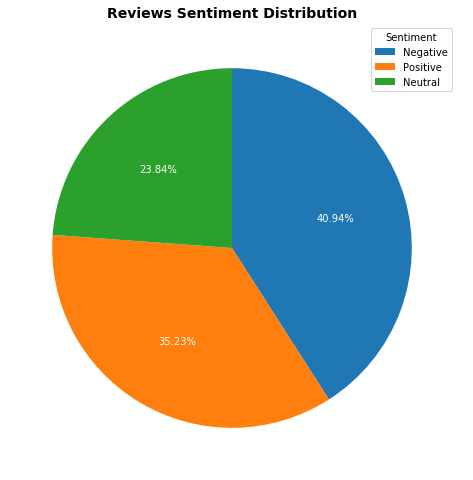

In [38]:
"""
#sns.countplot(data = df_clean,
#              x = polarity).set_title('Polarity of Reviews')

ax = sns.countplot(data = df_clean,
                 x = polarity)
ax.set_title('Polarity of Reviews')
ax.set_xlabel('Polarity')
ax.set_ylabel('Number of Reviews');
"""

# Pie to show distribution
plt.figure(figsize=[14.70, 8.27])
plt.pie(sentiments, 
        labels =sentiments.index, 
        startangle = 90, 
        autopct= '%1.2f%%', 
        counterclock = False,
        textprops={'color':'white'});
plt.legend(sentiments.index,  
           title='Sentiment', 
           loc='upper right')
plt.title('Reviews Sentiment Distribution', fontsize=14,  fontweight='bold');

In [41]:
# Split into testing set and training set
x_train, x_test, y_train, y_test = train_test_split(
    df_clean['stemming_text'], df_clean['sentiment'], random_state=0)

In [44]:
# Vectorize X_train
vectorizer = TfidfVectorizer(min_df = 5).fit(x_train)
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))

feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

X_train:
<6683x2074 sparse matrix of type '<class 'numpy.float64'>'
	with 66625 stored elements in Compressed Sparse Row format>
Number of features: 2074


#### Logistic Regression

In [52]:
# Logistic Regression with TF-IDF vectorizer
start_time = time.time()

logreg = LogisticRegression(C=0.1, solver='lbfgs', multi_class='auto', max_iter=3000).fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

log_y_pred = logreg.predict(X_test)

print("Logistic Regression (TF-IDF):")

#print("Training set score: {}".format(logreg.score(X_train, y_train))) #Same with accuracy
#print("Test set score: {}".format(logreg.score(X_test, y_test)))

log_accuracy = accuracy_score(y_test, log_y_pred)
print("Accuracy score:   {}".format(log_accuracy))

log_precision = precision_score(y_test, log_y_pred, average='macro')
print("Precision score: {}".format(log_precision))

log_recall = recall_score(y_test, log_y_pred, average='macro')
print("Recall score: {}".format(log_recall))

log_f1 = f1_score(y_test, log_y_pred, average='macro')
print("F1 score: {}".format(log_f1))

log_time = time.time() - start_time
print("--- %s seconds ---" % (log_time))

Logistic Regression (TF-IDF):
Accuracy score:   0.7944344703770198
Precision score: 0.8383797889898993
Recall score: 0.7473904715440716
F1 score: 0.7644364597063203
--- 0.18441438674926758 seconds ---


#### Decision Tree

In [55]:
# Decision Tree with TF-IDF vectorizer
start_time = time.time()

decision_tree = DecisionTreeClassifier().fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

decisionTree_y_pred = decision_tree.predict(X_test)

print("Decision Tree (TF-IDF):")

#print("Training set score: {}".format(decision_tree.score(X_train, y_train)))
#print("Test set score: {}".format(decision_tree.score(X_test, y_test)))

decisionTree_accuracy = accuracy_score(y_test, log_y_pred)
print("Accuracy score:   {}".format(decisionTree_accuracy))

decisionTree_precision = precision_score(y_test, decisionTree_y_pred, average='macro')
print("Precision score: {}".format(decisionTree_precision))

decisionTree_recall = recall_score(y_test, decisionTree_y_pred, average='macro')
print("Recall score: {}".format(decisionTree_recall))

decisionTree_f1 = f1_score(y_test, decisionTree_y_pred, average='macro')
print("F1 score: {}".format(decisionTree_f1))

decisionTree_time = time.time() - start_time
print("--- %s seconds ---" % (decisionTree_time))

Decision Tree (TF-IDF):
Accuracy score:   0.7944344703770198
Precision score: 0.8819752456127934
Recall score: 0.8853287606108823
F1 score: 0.8835693204327385
--- 0.37702059745788574 seconds ---


#### Random Forest

In [56]:
# Random Forest with TF-IDF vectorizer
start_time = time.time()

random_forest = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

rf_pred = random_forest.predict(X_test)

print("Random Forest (TF-IDF):")

#print("Training set score: {}".format(random_forest.score(X_train, y_train)))
#print("Test set score: {}".format(random_forest.score(X_test, y_test)))

rf_accuracy = accuracy_score(y_test, rf_pred)
print("Accuracy:   {}".format(rf_accuracy))

rf_precision = precision_score(y_test, rf_pred, average='macro')
print("Precision: {}".format(rf_precision))

rf_recall = recall_score(y_test, rf_pred, average='macro')
print("Recall: {:.3f}".format(rf_recall))

rf_f1 = f1_score(y_test, rf_pred, average='macro')
print("F1 score: {}".format(rf_f1))

#rf_cv = cross_val_score(RandomForestClassifier(n_estimators = 100), X_train, y_train, cv=5)
#print("Mean cross-validation accuracy: {:.3f}".format(np.mean(rf_cv)))

rf_time = time.time() - start_time
print("--- %s seconds ---" % (rf_time))

Random Forest (TF-IDF):
Accuracy:   0.9052962298025135
Precision: 0.898504360223908
Recall: 0.913
F1 score: 0.9040135689458358
--- 2.0619616508483887 seconds ---


#### Naive Bayes

In [57]:
# Naive Bayes with TF-IDF vectorizer
start_time = time.time()

multinomialNB = MultinomialNB().fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

multinomialNB_pred = multinomialNB.predict(X_test)
print("Naive Bayes (TF-IDF):")

#print("Training set score: {}".format(multinomialNB.score(X_train, y_train)))
#print("Test set score: {}".format(multinomialNB.score(X_test, y_test)))

multinomialNB_accuracy = accuracy_score(y_test, multinomialNB_pred)
print("Accuracy:   {}".format(multinomialNB_accuracy))

multinomialNB_precision = precision_score(y_test, multinomialNB_pred, average='macro')
print("Precision: {}".format(multinomialNB_precision))

multinomialNB_recall = recall_score(y_test, multinomialNB_pred, average='macro')
print("Recall: {}".format(multinomialNB_recall))

multinomialNB_f1 = f1_score(y_test, multinomialNB_pred, average='macro')
print("F1 score: {}".format(multinomialNB_f1))

multinomialNB_time = time.time() - start_time
print("--- %s seconds ---" % (multinomialNB_time))

Naive Bayes (TF-IDF):
Accuracy:   0.7877019748653501
Precision: 0.8002592794616404
Recall: 0.7502447599183881
F1 score: 0.7621770556183526
--- 0.0604395866394043 seconds ---


#### XGBoost

In [61]:
# XGBoost with TF-IDF vectorizer
start_time = time.time()

xgb = XGBClassifier().fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

xgb_y_pred = xgb.predict(X_test)

print("XGBoost (TF-IDF):")

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print("Accuracy:   {}".format(xgb_accuracy))

#print("Training set score: {}".format(xgb.score(X_train, y_train)))
#print("Test set score: {}".format(xgb.score(X_test, y_test)))

xgb_precision = precision_score(y_test, xgb_y_pred, average='macro')
print("Precision: {}".format(xgb_precision))

xgb_recall = recall_score(y_test, xgb_y_pred, average='macro')
print("Recall: {}".format(xgb_recall))

xgb_f1 = f1_score(y_test, xgb_y_pred, average='macro')
print("F1 score: {}".format(xgb_f1))

xgb_time = time.time() - start_time
print("--- %s seconds ---" % (xgb_time))

XGBoost (TF-IDF):
Accuracy:   0.8909335727109515
Precision: 0.8827571171450064
Recall: 0.8989137539421647
F1 score: 0.8875973226799262
--- 3.626474380493164 seconds ---


### SVM

In [63]:
# SVM with TF-IDF vectorizer
start_time = time.time()

svm = SVC(gamma='auto', kernel='linear').fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

svm_pred = xgb.predict(X_test)

print("SVM (TF-IDF):")

svm_accuracy = accuracy_score(y_test, svm_pred)
print("Accuracy:   {}".format(svm_accuracy))

#print("Training set score: {}".format(xgb.score(X_train, y_train)))
#print("Test set score: {}".format(xgb.score(X_test, y_test)))

svm_precision = precision_score(y_test, svm_pred, average='macro')
print("Precision: {}".format(svm_precision))

svm_recall = recall_score(y_test, svm_pred, average='macro')
print("Recall: {}".format(svm_recall))

svm_f1 = f1_score(y_test, svm_pred, average='macro')
print("F1 score: {}".format(svm_f1))

svm_time = time.time() - start_time
print("--- %s seconds ---" % (svm_time))

SVM (TF-IDF):
Accuracy:   0.8909335727109515
Precision: 0.8827571171450064
Recall: 0.8989137539421647
F1 score: 0.8875973226799262
--- 2.2461845874786377 seconds ---


In [65]:
# Append metrics for each models into a list
log_metrics = ['Logistic Regression', log_accuracy, log_precision, log_recall, log_f1, log_time]
decisionTree_metrics = ['Decison Tree', decisionTree_accuracy, decisionTree_precision, decisionTree_recall, decisionTree_f1, decisionTree_time]
rf_metrics = ['Random Forest', rf_accuracy, rf_precision, rf_recall, rf_f1, rf_time]
multinomialNB_metrics = ['Multinomial Naive Bayes', multinomialNB_accuracy, multinomialNB_precision, multinomialNB_recall, multinomialNB_f1, multinomialNB_time]
svm_metrics = ['SVM (Linear)', svm_accuracy, svm_precision, svm_recall, svm_f1, svm_time]
xgb_metrics = ['XG Boost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_time]

# Append all metric list into a list
metricsList = [log_metrics, decisionTree_metrics, rf_metrics, multinomialNB_metrics, svm_metrics, xgb_metrics]

# Convert list to dataframe
metricDF = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Time (s)'], data = metricsList)
metricDF

,Model,Accuracy,Precision,Recall,F1 Score,Time (s)
0,Logistic Regression,0.794434,0.838380,0.747390,0.764436,0.184414
1,Decison Tree,0.794434,0.881975,0.885329,0.883569,0.377021
2,Random Forest,0.905296,0.898504,0.912628,0.904014,2.061962
3,Multinomial Naive Bayes,0.787702,0.800259,0.750245,0.762177,0.060440
4,SVM (Linear),0.890934,0.882757,0.898914,0.887597,2.246185
5,XG Boost,0.890934,0.882757,0.898914,0.887597,3.626474
